# Movie project

## Imports

In [1]:
import os
import ast
import json
import nltk
import string
import gensim
import pickle
import statistics
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.svm import SVR
from textblob import TextBlob
import matplotlib.pyplot as plt
from sklearn import preprocessing
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.linear_model import Ridge
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from scipy.stats.mstats import winsorize
import sklearn.feature_extraction.text as text
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from nltk.stem import SnowballStemmer,PorterStemmer
from sklearn.model_selection import  GridSearchCV, train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report, f1_score
import warnings
warnings.simplefilter("ignore")
# Download required resources (only needed once)
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

# Data Gathering

In [2]:
movies = pd.read_csv("D:\movies-classification\movies-classification\movies-classification-dataset.csv");

In [3]:
credits = pd.read_csv("D:\movies-classification\movies-classification\movies-credit-students-train.csv");

In [4]:
credits.rename(columns = {'movie_id':'id'}, inplace = True)

In [5]:
data = movies.merge(credits,on='id')

In [6]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3033 entries, 0 to 3032
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                3033 non-null   int64  
 1   genres                3033 non-null   object 
 2   homepage              1125 non-null   object 
 3   id                    3033 non-null   int64  
 4   keywords              3033 non-null   object 
 5   original_language     3033 non-null   object 
 6   original_title        3033 non-null   object 
 7   overview              3032 non-null   object 
 8   viewercount           3033 non-null   float64
 9   production_companies  3033 non-null   object 
 10  production_countries  3033 non-null   object 
 11  release_date          3033 non-null   object 
 12  revenue               3033 non-null   int64  
 13  runtime               3032 non-null   float64
 14  spoken_languages      3033 non-null   object 
 15  status               

In [7]:
print("The number of unique values of 'id' column ",len(data['id'].unique()))

The number of unique values of 'id' column  3033


In [8]:
print("The number of unique values of 'tagline' column ",len(data['tagline'].unique()))

The number of unique values of 'tagline' column  2643


In [9]:
print("The unique values and its count of the status column :")
print(data['status'].value_counts())

The unique values and its count of the status column :
Released           3032
Post Production       1
Name: status, dtype: int64


In [10]:
data.drop(columns=['id','title_x','status'],inplace=True)#title_x ,title_y is the same so we droped one of them
data.rename(columns={'title_y':'title'},inplace=True)# change name of title_y to title
data.drop(columns=['overview','homepage'],inplace=True)

In [11]:
#save mode of release_data for test script
date_mode = data['release_date'].mode()[0]
pickle.dump(date_mode, open("date_mode_c.pkl", "wb"))

In [12]:
#Remove one Row is null
data.dropna(subset=['runtime'],inplace=True)

# Release date Pre-Processing

In [13]:
#split release_date column to 3 columns [day,month,year]
data['day'] = pd.to_datetime(data['release_date']).dt.day # drop if it is not needed
data['month'] = pd.to_datetime(data['release_date']).dt.month
data['year'] = pd.to_datetime(data['release_date']).dt.year

In [14]:
data.drop(columns=['release_date'],inplace=True)

In [15]:
data.head()

,budget,genres,keywords,original_language,original_title,viewercount,production_companies,production_countries,revenue,runtime,spoken_languages,tagline,vote_count,Rate,title,cast,crew,day,month,year
0,25000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""n...","[{""id"": 4328, ""name"": ""costume""}, {""id"": 4528,...",en,Mao's Last Dancer,1.876811,"[{""name"": ""Great Scott Productions Pty. Ltd."",...","[{""iso_3166_1"": ""AU"", ""name"": ""Australia""}]",20719451,117.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",最后的舞者,28,High,Mao's Last Dancer,"[{""cast_id"": 2, ""character"": ""Li Cunxin - adul...","[{""credit_id"": ""52fe45419251416c9102c18d"", ""de...",1,10,2009
1,38000000,"[{""id"": 878, ""name"": ""Science Fiction""}, {""id""...","[{""id"": 10988, ""name"": ""based on tv series""}, ...",en,Star Trek: Generations,14.779041,"[{""name"": ""Paramount Pictures"", ""id"": 4}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",120000000,118.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Boldly go.,452,Intermediate,Star Trek: Generations,"[{""cast_id"": 5, ""character"": ""Captain Jean-Luc...","[{""credit_id"": ""52fe4225c3a36847f8007717"", ""de...",17,11,1994
2,20000000,"[{""id"": 36, ""name"": ""History""}, {""id"": 18, ""na...","[{""id"": 237, ""name"": ""gay""}, {""id"": 582, ""name...",en,Milk,30.909699,"[{""name"": ""Focus Features"", ""id"": 10146}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",54586584,128.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Never Blend In.,612,High,Milk,"[{""cast_id"": 2, ""character"": ""Harvey Milk"", ""c...","[{""credit_id"": ""52fe43339251416c7500756b"", ""de...",26,11,2008
3,23000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""n...","[{""id"": 212, ""name"": ""london england""}, {""id"":...",en,Vanity Fair,6.618149,"[{""name"": ""Alliance Films"", ""id"": 2514}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",16123851,141.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...","On September 1st, a heroine will rise.",73,Intermediate,Vanity Fair,"[{""cast_id"": 22, ""character"": ""Becky Sharp"", ""...","[{""credit_id"": ""52fe446c9251416c75034365"", ""de...",1,9,2004
4,52000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 90, ""name"": ""paris""}, {""id"": 591, ""nam...",en,From Paris with Love,27.916284,"[{""name"": ""Apipoula\u00ef"", ""id"": 1076}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",52826594,92.0,"[{""iso_639_1"": ""de"", ""name"": ""Deutsch""}, {""iso...",Two agents. One city. No merci.,675,Intermediate,From Paris with Love,"[{""cast_id"": 3, ""character"": ""Charlie Wax"", ""c...","[{""credit_id"": ""5763f7b792514134cd00026b"", ""de...",5,2,2010


# Data Split

In [16]:
data_input=data.drop(columns=['Rate'])
data_output=data['Rate']

In [17]:
x_train ,x_test ,y_train ,y_test = train_test_split(data_input ,data_output ,test_size = 0.2 ,random_state = 21)

<AxesSubplot:xlabel='Rate'>

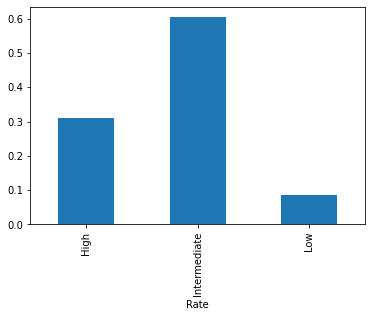

In [18]:
# grouping by frequency
fq =pd.DataFrame(y_train,columns=['Rate']).groupby('Rate').size()/len(y_train)
fq.plot.bar(stacked=True)

In [19]:
#encoding ordinal for Rate column and save it for test script
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
oe.fit(np.array(y_train).reshape(-1, 1))
pickle.dump(oe, open("ordinal_encoder.pkl", "wb"))
y_train = oe.transform(np.array(y_train).reshape(-1, 1))
y_test = oe.transform(np.array(y_test).reshape(-1, 1))

In [20]:
print("Shape of train data is ",x_train.shape)
print("Shape of test data is ",x_test.shape)

Shape of train data is  (2425, 19)
Shape of test data is  (607, 19)


## Preprocessing The "Title" and "Original title" Columns by removing the noise

In [21]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Define a function to remove punctuation and stopwords and apply lemmatization
def preprocess_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize words
    words = nltk.word_tokenize(text)
    # Remove stopwords and apply lemmatization
    words = [lemmatizer.lemmatize(word) for word in words if not word.lower() in stop_words]
    # Join words into a sentence
    text = " ".join(words)
    return text

# Apply preprocessing on 'original_title' and 'title' on train and test
x_train['original_title'] = x_train['original_title'].apply(preprocess_text)
x_test['original_title'] = x_test['original_title'].apply(preprocess_text)
x_train['title'] = x_train['title'].apply(preprocess_text)
x_test['title'] = x_test['title'].apply(preprocess_text)

In [22]:
# make new column to display differnce between title and original title
x_train['original_title'] = x_train['original_title'].str.lower()
x_train['title'] = x_train['title'].str.lower()
x_train['original_title_not_equal_title'] = x_train['original_title'] != x_train['title']
rows_not_equal = x_train[x_train['original_title_not_equal_title']]
print("The differnet rows between 'title' column and 'original_title' column in train data:")
rows_not_equal[['title','original_title']]

The differnet rows between 'title' column and 'original_title' column in train data:


,title,original_title
1346,tango,tango dejes nunca
487,warlords,投名狀
2482,kung fu hustle,功夫
1927,best offer,la migliore offerta
455,girl train,la fille du rer
...,...,...
1994,futuro beach,praia futuro
1362,forbidden kingdom,viy
2391,kabhi alvida naa kehna,कभी अलविदा ना कहना
2356,fly moon,un plan parfait


In [23]:
# make the same on test
x_test['original_title'] = x_test['original_title'].str.lower()
x_test['title'] = x_test['title'].str.lower()
x_test['original_title_not_equal_title'] = x_test['original_title'] != x_test['title']
rows_not_equal = x_test[x_test['original_title_not_equal_title']]
print("The differnet rows between 'title' column and 'original_title' column in test data:")
rows_not_equal[['title','original_title']]

The differnet rows between 'title' column and 'original_title' column in test data:


,title,original_title
2987,diving bell butterfly,le scaphandre et le papillon
2804,instructions included,se aceptan devoluciones
2835,children huang shi,黃石的孩子
1958,exiled,放‧逐
1217,reign assassins,剑雨
370,chorus,les choristes
2310,highlander final dimension,highlander iii sorcerer
972,character,karakter
2042,micmacs,micmacs à tirelarigot
552,lilya 4ever,lilja 4ever


In [24]:
x_train.drop(columns=['original_title_not_equal_title'],inplace=True)
x_test.drop(columns=['original_title_not_equal_title'],inplace=True)

In [25]:
# This Column is similar to "Tiltle" Column with number of rows 2897 to the original data 3040 rows
x_train.drop(axis=1, columns=['original_title'], inplace=True)
x_test.drop(axis=1, columns=['original_title'], inplace=True)

# Preprocessing The "Tagline" and "Title" using sentiment analysis

In [26]:
#fill null with empty string
x_train['tagline'] = x_train['tagline'].astype(str).fillna('')
x_test['tagline'] = x_test['tagline'].astype(str).fillna('')

In [27]:
# Define a function to get the sentiment score of a movie title and tagline using TextBlob
def get_sentiment_score(title):
    text_blob = TextBlob(title)
    return text_blob.sentiment.polarity

# Apply the function to the 'title' column of the DataFrame to get the sentiment scores
x_train['title'] = x_train['title'].apply(get_sentiment_score)
x_test['title'] = x_test['title'].apply(get_sentiment_score)

x_train['tagline'] = x_train['tagline'].apply(get_sentiment_score)
x_test['tagline'] = x_test['tagline'].apply(get_sentiment_score)

# Detect and Handling Outliers

In [28]:
x_train = x_train.reset_index(drop=True)

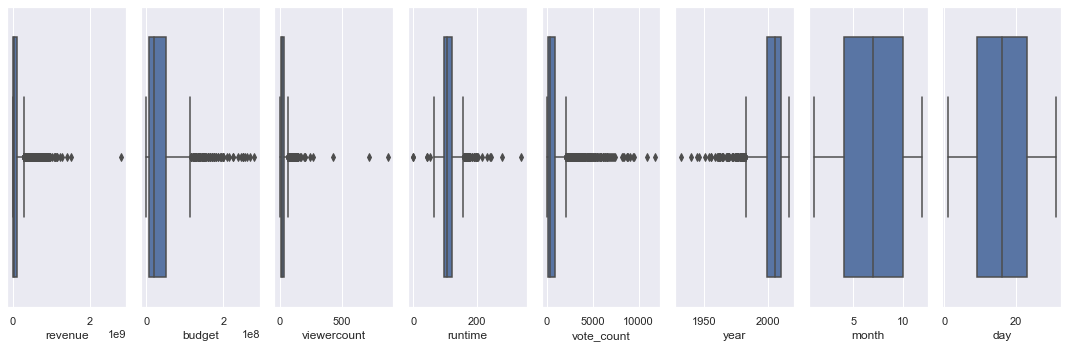

In [29]:
#checking outliers of train data
sns.set()
fig, axs = plt.subplots(1,8, figsize = (15,5))
plt1 = sns.boxplot(x_train['revenue'], ax = axs[0])
plt2 = sns.boxplot(x_train['budget'], ax = axs[1])
plt3 = sns.boxplot(x_train['viewercount'], ax = axs[2])
plt4 = sns.boxplot(x_train['runtime'], ax = axs[3])
plt5 = sns.boxplot(x_train['vote_count'], ax = axs[4])
plt6 = sns.boxplot(x_train['year'], ax = axs[5])
plt7 = sns.boxplot(x_train['month'], ax = axs[6])
plt8 = sns.boxplot(x_train['day'], ax = axs[7])

plt.tight_layout()

In [30]:
x_test = x_test.reset_index(drop=True)

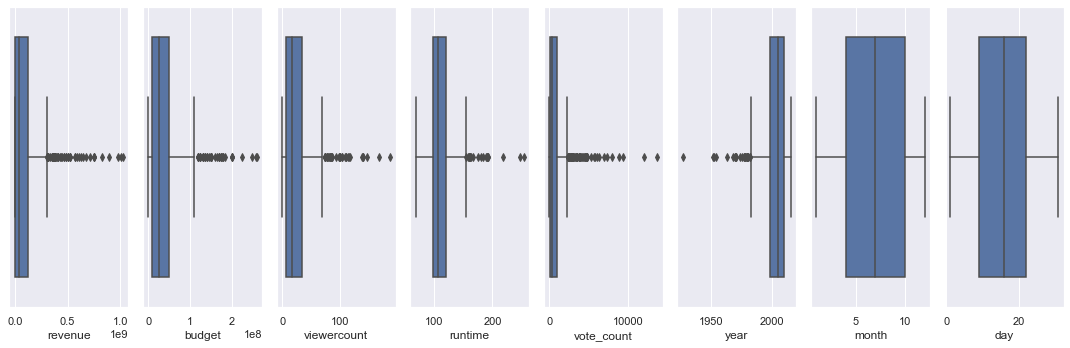

In [31]:
#checking outliers of testing data
sns.set()
fig, axs = plt.subplots(1,8, figsize = (15,5))
plt1 = sns.boxplot(x_test['revenue'], ax = axs[0])
plt2 = sns.boxplot(x_test['budget'], ax = axs[1])
plt3 = sns.boxplot(x_test['viewercount'], ax = axs[2])
plt4 = sns.boxplot(x_test['runtime'], ax = axs[3])
plt5 = sns.boxplot(x_test['vote_count'], ax = axs[4])
plt6 = sns.boxplot(x_test['year'], ax = axs[5])
plt7 = sns.boxplot(x_test['month'], ax = axs[6])
plt8 = sns.boxplot(x_test['day'], ax = axs[7])

plt.tight_layout()

In [32]:
# handling outlier of train and test using knowledge of outliers of train
def replace_outlier(col):
    limits=[]
    col_q1=x_train[col].quantile(0.25)
    col_q3=x_train[col].quantile(0.75)
    col_iqr=col_q3-col_q1

    col_upper_limit=col_q3+(1.5*col_iqr)
    col_lower_limit=col_q1-(1.5*col_iqr)

    limits.append(col_upper_limit)
    limits.append(col_lower_limit)

    x_train.loc[x_train[col] > col_upper_limit,col]= col_upper_limit
    x_train.loc[x_train[col] < col_lower_limit,col]= col_lower_limit
    return limits

def replace_test_outlier(col,limits):
    x_test.loc[x_test[col] > limits[0],col]=limits[0]
    x_test.loc[x_test[col] < limits[1],col]=limits[1]

In [33]:
 # define list to use in test script
limit_values = []

In [34]:
outliers_column=['revenue','budget','runtime','vote_count','viewercount','year']
for col in outliers_column:
    limits=replace_outlier(col)
    #append the outliers value into list to apply on test script
    limit_values.append(limits)
    replace_test_outlier(col,limits)

In [35]:
# save list of train outliers 
pickle.dump(limit_values, open("limit_values_c.pkl", "wb"))

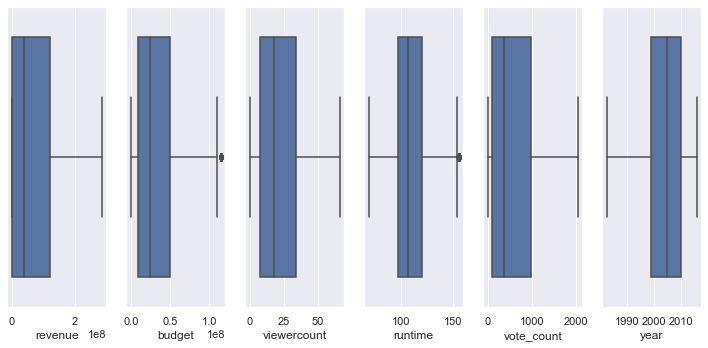

In [36]:
#checking outliers test
sns.set()
fig, axs = plt.subplots(1,6, figsize = (10,5))
plt7 = sns.boxplot(x_test['revenue'], ax = axs[0])
plt2 = sns.boxplot(x_test['budget'], ax = axs[1])
plt3 = sns.boxplot(x_test['viewercount'], ax = axs[2])
plt4 = sns.boxplot(x_test['runtime'], ax = axs[3])
plt5 = sns.boxplot(x_test['vote_count'], ax = axs[4])
plt6 = sns.boxplot(x_test['year'], ax = axs[5])

plt.tight_layout()

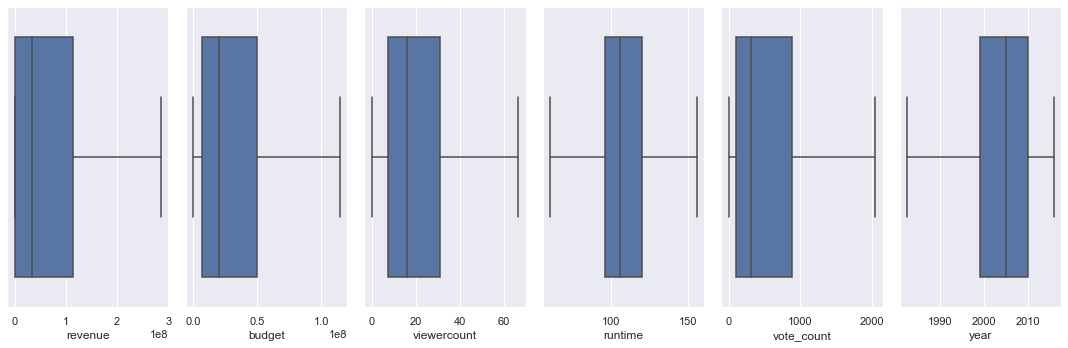

In [37]:
#checking outliers train
sns.set()
fig, axs = plt.subplots(1,6, figsize = (15,5))
plt1 = sns.boxplot(x_train['revenue'], ax = axs[0])
plt2 = sns.boxplot(x_train['budget'], ax = axs[1])
plt3 = sns.boxplot(x_train['viewercount'], ax = axs[2])
plt4 = sns.boxplot(x_train['runtime'], ax = axs[3])
plt5 = sns.boxplot(x_train['vote_count'], ax = axs[4])
plt6 = sns.boxplot(x_train['year'], ax = axs[5])
plt.tight_layout()

# Handling Missing Values of "budget" and "runtime" Columns

In [38]:
budget_mean = x_train[x_train["budget"] > 0].budget.describe().mean()
runtime_mean=  x_train[x_train["runtime"] > 0].runtime.describe().mean()

In [39]:
pickle.dump(budget_mean, open("budget_mean_c.pkl", "wb"))
pickle.dump(runtime_mean, open("runtime_mean_c.pkl", "wb"))

In [40]:
x_train['budget'].replace(0, budget_mean,inplace = True)
x_train['runtime'].replace(0, runtime_mean,inplace = True)

x_test['budget'].replace(0, budget_mean, inplace = True)
x_test['runtime'].replace(0, runtime_mean, inplace = True)

# Preprocessing The "original_language" Column using ordinal encoder

In [41]:
# Get unique values of "original_language" column
unique_values = x_train['original_language'].unique()
print(f"Unique values of 'original_language' column: {unique_values}")

Unique values of 'original_language' column: ['en' 'hi' 'es' 'zh' 'fr' 'cn' 'de' 'ja' 'sv' 'ko' 'nl' 'ru' 'th' 'ta'
 'cs' 'hu' 'it' 'is' 'da' 'pt']


In [42]:
# The most frequently occurring value in the column
OL_mode = x_train['original_language'].mode()[0]     

In [43]:
pickle.dump(OL_mode, open("OL_mode_c.pkl", "wb"))

In [44]:
# Fit the ordinal encoder and save it to a file
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
oe.fit(x_train[['original_language']])

# Save the encoder to a file using pickle
with open('encoder_c.pkl', 'wb') as f:
    pickle.dump(oe, f)

# Transform "original_language" column for both training and test sets
x_train['original_language'] = oe.transform(x_train[['original_language']])
x_test['original_language'] = oe.transform(x_test[['original_language']])

# Extracting the "name" attribute from the Columns

In [45]:
json_cols = ['genres', 'keywords', 'production_companies', 'spoken_languages', 'production_countries', 'cast', 'crew']

def extract_keywords(x):
    L=[]
    for i in ast.literal_eval(x):
            L.append(i['name'])
    return L

# Apply extract_keywords function to train data
for col in json_cols:
    x_train[col]=x_train[col].apply(extract_keywords)

# Apply extract_keywords function to test data
for col in json_cols:
    x_test[col]=x_test[col].apply(extract_keywords)

# One Hot Encoding

In [46]:
class Our_OneHotEncoder:
    data = set()

    def _init_(self):
        self.data.clear()

    # adding items to data field
    def fit_freq(self, freq_set):
        self.data = freq_set

    def fit(self, df, column_name):
        # adding items to data field
        for lst in df[column_name]:
            for element in lst:
                self.data.add(element)

    def transform(self, df, column_name):
        data_lst = list(self.data)

        # Initializing the one-hot columns
        for col in data_lst:
            df[col] = np.zeros(df.shape[0], dtype=int)

        # One-Hot Encoding
        for i, row in df.iterrows():
            for element in row[column_name]:
                if element in data_lst:
                    df.loc[i, element] = 1
        df.drop(columns=[column_name], inplace=True)


saved_fitted_data = []
encoder = Our_OneHotEncoder()
encoder.fit(x_train, 'genres')
saved_fitted_data.append(list(encoder.data))
encoder.transform(x_train, 'genres')
encoder.transform(x_test, 'genres')

arr = [60, 20, 20]
most_common_cols = ['production_companies', 'production_countries', 'cast']
i = 0

for col in most_common_cols:
    keywords_freq = set()
    
    # Flatten the list of keywords into a single list of words
    words = [keyword for keyword_list in x_train[col] for keyword in keyword_list]

    freq_count = Counter(words)
    
    for word, count in freq_count.most_common(arr[i]):
        if word not in list(stop_words):
            # print(word, count)
            keywords_freq.add(word)
    i += 1
    encoder = Our_OneHotEncoder()
    encoder.fit_freq(keywords_freq)
    saved_fitted_data.append(list(encoder.data))
    encoder.transform(x_train, col)
    encoder.transform(x_test, col)


In [47]:
pickle.dump(saved_fitted_data, open("saved_fitted_data_c.pkl", "wb"))

# Preprocessing "keywords","crew","spoken_languages" by word2vector

In [48]:
word2vectorColumns=['keywords', 'crew', 'spoken_languages']

def word2vectorFunction(data, col):
    model1 = gensim.models.Word2Vec(data[col],  min_count = 1)
    X = []
    for keyword in data[col]:
        feature_vec = np.zeros((100,))
        for word in keyword:
            if word in model1.wv.key_to_index:
                feature_vec += model1.wv[word]
        X.append(feature_vec)
    data[col] = X
    
for col in word2vectorColumns:
    word2vectorFunction(x_train,col)
    word2vectorFunction(x_test,col)

# Calculating mean

In [49]:
import statistics
from statistics import mean
columns = ['keywords', 'crew', 'spoken_languages']   

def calculate_mean(df, col):
    for i, row in df.iterrows():
        df.loc[i, col] = mean(df.loc[i, col])
        
for col in columns:
    calculate_mean(x_train, col)
    calculate_mean(x_test, col)

In [50]:
vote_count_med = x_train['vote_count'].median()

In [51]:
viewer_count_med = x_train['viewercount'].median()

In [52]:
revnue_med = x_train['revenue'].median()

In [53]:
pickle.dump(vote_count_med, open("vote_count_med_c.pkl", "wb"))
pickle.dump(viewer_count_med, open("viewer_count_med_c.pkl", "wb"))
pickle.dump(revnue_med, open("revnue_med_c.pkl", "wb"))

# Scaling

In [54]:
cols=['budget','viewercount','revenue','runtime','vote_count','year','month','day', 'keywords','crew', 'spoken_languages']
scaler = StandardScaler()
scaler.fit(x_train[cols])
with open('scaler_c.pkl', 'wb') as f:
    pickle.dump(scaler, f)
x_train[cols]=scaler.transform(x_train[cols])
x_test[cols]=scaler.transform(x_test[cols])
print(x_train.head())

     budget  keywords  original_language  viewercount   revenue   runtime  \
0 -0.829751  0.499768                4.0     2.414452 -0.296574  2.607843   
1  0.075130 -0.288890                4.0    -0.285527 -0.508565  0.001692   
2 -0.096073 -0.087141                4.0    -0.177130 -0.816813 -1.218208   
3  2.571931  0.306559                4.0     1.597931  2.312327 -0.996408   
4  0.075130 -0.614079                4.0    -0.594435 -0.816813  0.999792   

   spoken_languages  tagline  vote_count  title  ...  Steve Buscemi  \
0          1.601773     0.00    2.195619    0.0  ...              0   
1         -0.416439     0.00   -0.381870    0.0  ...              0   
2         -0.416439     0.00   -0.384904    0.0  ...              0   
3         -0.416439     0.00    1.942270    0.0  ...              0   
4         -0.416439    -0.15    0.183994    0.0  ...              0   

   Nicolas Cage  Meryl Streep  Matthew McConaughey  Stanley Tucci  \
0             0             0            

## Feature Selection

In [55]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# X is the feature matrix and y is the target variable
# Create a logistic regression object
lr = LogisticRegression()

# Create the RFE object and select 10 features
rfe = RFE(lr, n_features_to_select=80)

# Fit the RFE object to the data
rfe.fit(x_train, y_train)

# Print the selected features
print(x_train.columns[rfe.support_])

Index(['budget', 'viewercount', 'runtime', 'tagline', 'vote_count', 'year',
       'Documentary', 'War', 'Music', 'Science Fiction', 'Action', 'Animation',
       'TV Movie', 'Crime', 'Drama', 'Horror', 'Comedy',
       'Happy Madison Productions', 'TSG Entertainment', 'Film4',
       'Summit Entertainment', 'Original Film', 'Canal+',
       'DreamWorks Animation', 'StudioCanal', 'Regency Enterprises',
       'BBC Films', 'Spyglass Entertainment', 'UK Film Council',
       'The Weinstein Company', 'Castle Rock Entertainment', 'United Artists',
       'Paramount Pictures', 'TriStar Pictures', 'MTV Films',
       'Dimension Films', 'Working Title Films', 'Ingenious Film Partners',
       'Columbia Pictures Corporation', 'New Regency Pictures',
       'Walt Disney Pictures', 'NPV Entertainment', 'Silver Pictures',
       'Lionsgate', 'Davis Entertainment', 'Fox Searchlight Pictures',
       'Morgan Creek Productions', 'Warner Bros.', 'Hollywood Pictures',
       'Scott Free Productions', 

In [56]:
filterd_Cols = x_train.columns[rfe.support_]
pickle.dump(filterd_Cols, open("filterd_Cols.pkl", "wb"))

In [57]:
x_train = x_train[filterd_Cols]

x_test = x_test[filterd_Cols]

In [58]:
print("shape of train data after selection is ",x_train.shape)

shape of train data after selection is  (2425, 80)


In [59]:
print("shape of test data after selection is ",x_test.shape)

shape of test data after selection is  (607, 80)


In [60]:
def show_matrix(ax, y, y_pred):
    cm = confusion_matrix(y, y_pred)

    fig = ax.figure
    fig.set_size_inches(50, 20)  # Set the width to 10 inches and height to 6 inches

    # Create the heatmap using seaborn
    sns.heatmap(cm, annot=True, cmap='Blues', ax=ax)

In [61]:
# find the training accurracy
def model_prediction(model,data,y,_type,model_name):
    y_pred = model.predict(data)
    accuracy = accuracy_score(y, y_pred)
    print(f"{_type} Accuracy of {model_name}:", accuracy)

In [62]:
# find the test accurracy
def predictWithMatrix(model,data,y,_type,model_name):
    
    start_test_time = time.time()
    y_pred = model.predict(data)
    end_test_time = time.time()
    
    accuracy = accuracy_score(y, y_pred)
    
    print(f"{_type} Accuracy of {model_name}:", accuracy)
    total_test_time = end_test_time - start_test_time
    
    print("Test time:", total_test_time, "seconds")
    
    
    show_matrix(ax[0], y, y_pred)
    ax[0].set_title('Confusion Matrix')
    
    # Plot bar graphs for accuracy, training time, and testing time
    
    ax[1].bar([f"Test accuracy of {model_name}"], [accuracy], color=["blue"])
    ax[1].set_title('Classification accuracy')
    ax[1].set_ylim([0.0, 1])
    ax[1].set_yticks(np.arange(0, 1, step=0.05))
    
    ax[2].bar(["Total Testing Time"], [total_test_time], color=["#CD5C5C"])
    ax[2].set_title('Test Time')
    ax[2].set_ylim([0.0, 1])
    ax[2].set_yticks(np.arange(0, 1, step=0.05))
    

# Classification Models

### Obtaining the best parameters for the model based on the accuracy

In [63]:
# That class is obtaining the best parameters for the model based on the accuracy
import itertools
class HyperTuning:

    params_obtained = []
    params_accuracies = []
    df_params_acc = pd.DataFrame()
    best_params = []
    
    def __init__(self):
        self.df_params_acc.drop(index=self.df_params_acc.index, inplace=True, errors='ignore')
        self.params_accuracies.clear()
        self.params_obtained.clear()
        self.best_params.clear()
    
    def search(self, model, params, x_train, y_train, x_test, y_test):
        # Getting the combinations of parameters
        for combination in itertools.product(*params.values()):
            test_params = dict()
            for i, key in enumerate(params):
                test_params[key] = combination[i]
            
            self.params_obtained.append(test_params)
            
            # Now, lest's see its accuracy on the model
            model = type(model)(**test_params)
            model.fit(x_train, y_train)
            y_pred = model.predict(x_test)
            accuracy = accuracy_score(y_test, y_pred)
            self.params_accuracies.append(accuracy)

        
        
        self.df_params_acc['accuracy'] = self.params_accuracies
        self.df_params_acc['params'] = self.params_obtained
        
        # Then, let's search
        self.best_params = self.df_params_acc.loc[self.df_params_acc['accuracy'].idxmax(), 'params']
        return self.best_params
    
    def print_params_results(self):
        for i, row in self.df_params_acc.iterrows():
            print(f'accuracy: {row["accuracy"]}' + ' Params: ' + str(row['params']))

# -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-++-+-+-+-+-

# SVM after hyperparameter tuning

Train time: 0.7230446338653564 seconds
train Accuracy of svm: 0.8065979381443299
test Accuracy of svm: 0.7611202635914333
Test time: 0.34955310821533203 seconds


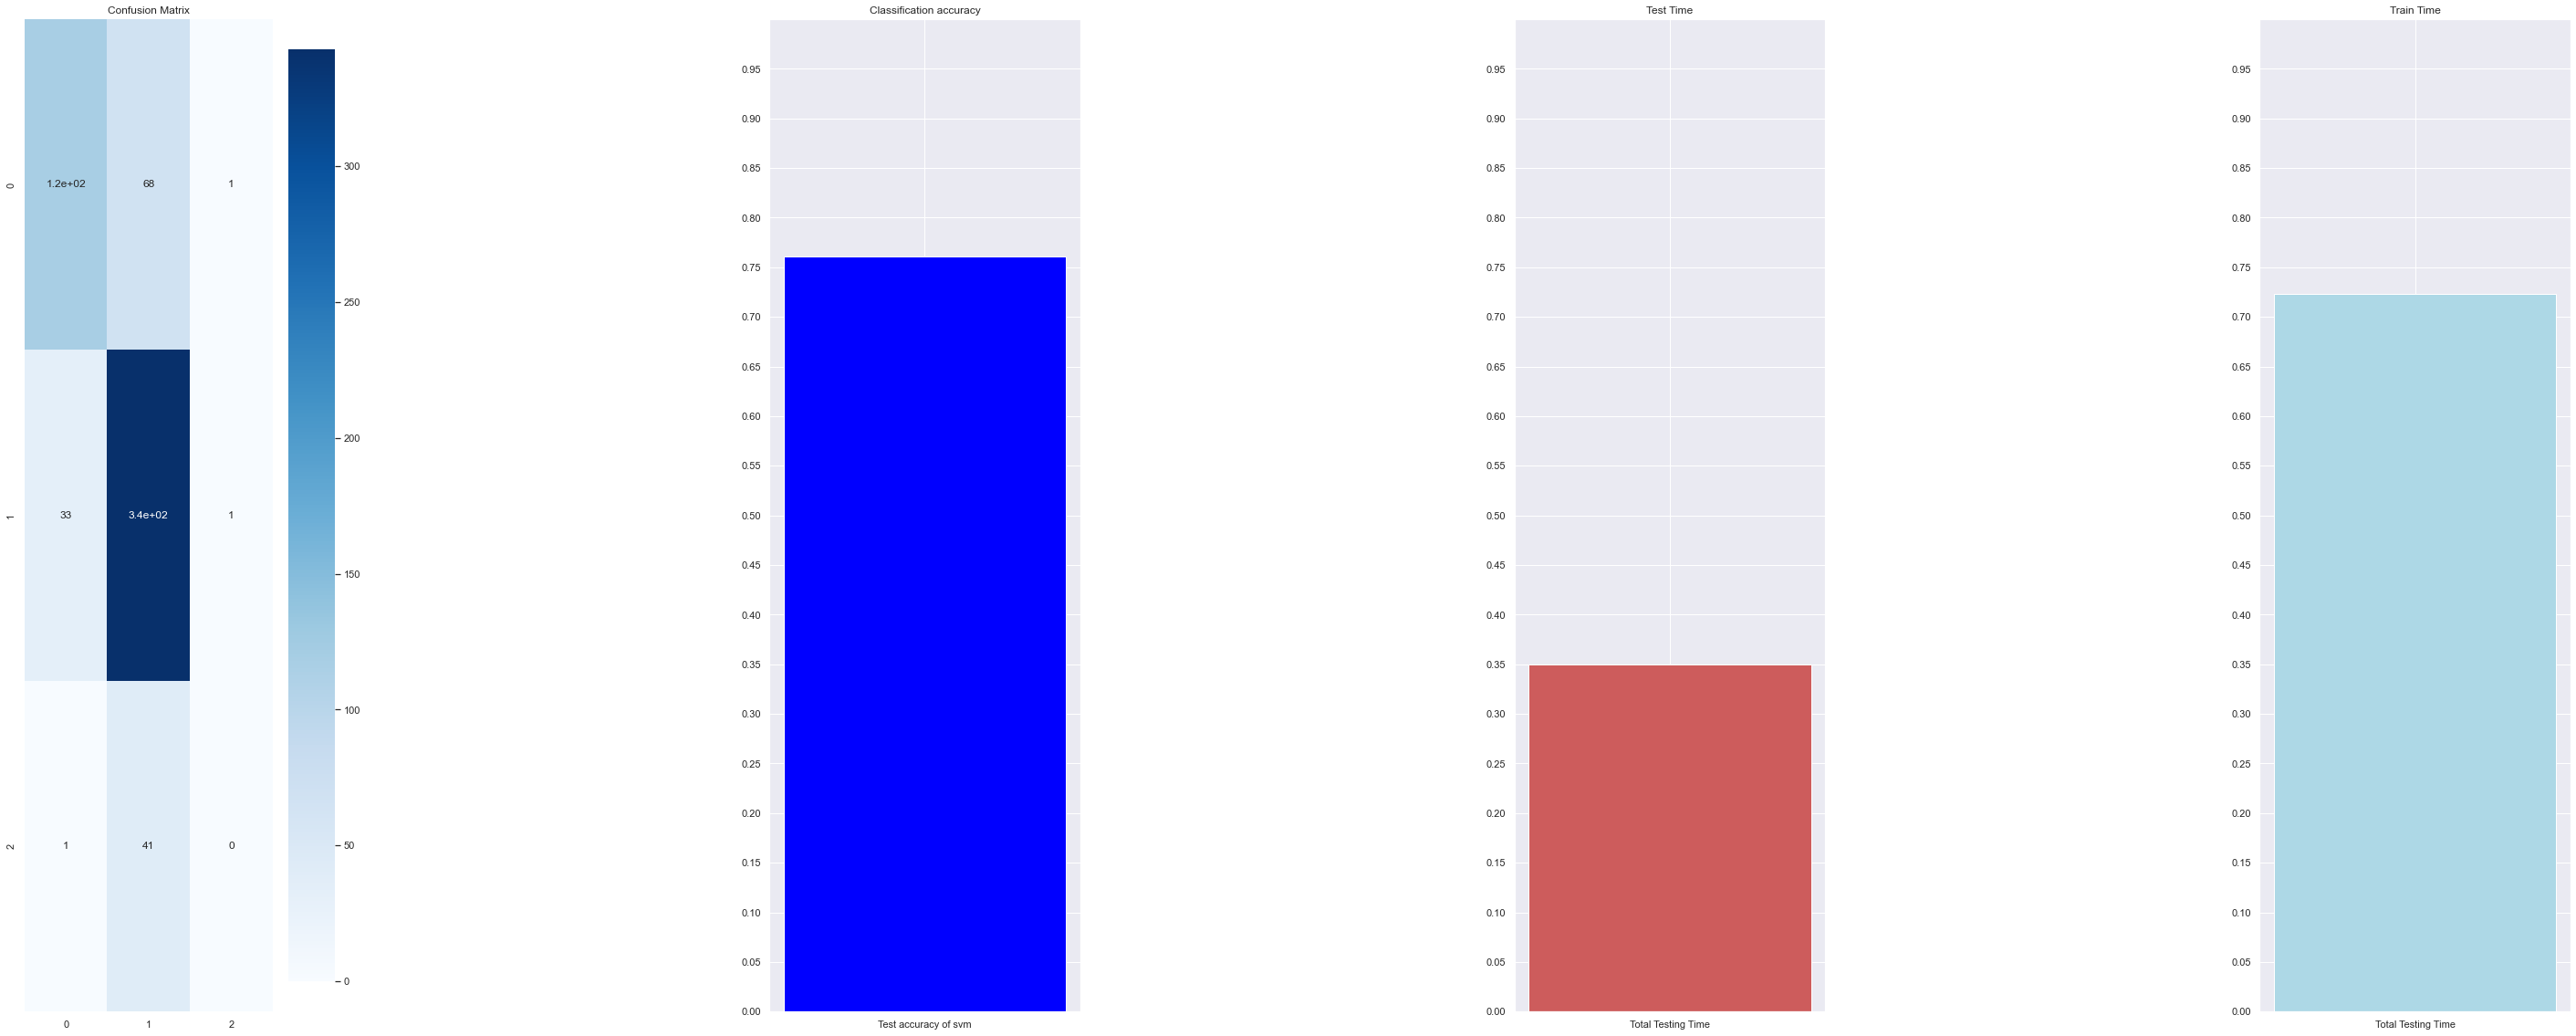

accuracy: 0.7215815485996705 Params: {'kernel': 'linear', 'C': 1, 'gamma': 'scale'}
accuracy: 0.7215815485996705 Params: {'kernel': 'linear', 'C': 1, 'gamma': 'auto'}
accuracy: 0.7199341021416804 Params: {'kernel': 'linear', 'C': 1.5, 'gamma': 'scale'}
accuracy: 0.7199341021416804 Params: {'kernel': 'linear', 'C': 1.5, 'gamma': 'auto'}
accuracy: 0.7166392092257001 Params: {'kernel': 'linear', 'C': 2.0, 'gamma': 'scale'}
accuracy: 0.7166392092257001 Params: {'kernel': 'linear', 'C': 2.0, 'gamma': 'auto'}
accuracy: 0.71499176276771 Params: {'kernel': 'linear', 'C': 2.2, 'gamma': 'scale'}
accuracy: 0.71499176276771 Params: {'kernel': 'linear', 'C': 2.2, 'gamma': 'auto'}
accuracy: 0.71499176276771 Params: {'kernel': 'linear', 'C': 2.4, 'gamma': 'scale'}
accuracy: 0.71499176276771 Params: {'kernel': 'linear', 'C': 2.4, 'gamma': 'auto'}
accuracy: 0.71499176276771 Params: {'kernel': 'linear', 'C': 2.6, 'gamma': 'scale'}
accuracy: 0.71499176276771 Params: {'kernel': 'linear', 'C': 2.6, 'gamma'

In [64]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier
import time
import numpy as np
import matplotlib.pyplot as plt

param_grid = { 'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], 'C': [1, 1.5, 2.0, 2.2, 2.4, 2.6,2.8], 'gamma': ['scale','auto'] }

svm_model = SVC()
tuning = HyperTuning()
best_params = tuning.search(svm_model, param_grid, x_train, y_train, x_test, y_test)

svm_model = SVC(**best_params)


# Record start time of training
start_train_time = time.time()

# Train the model
svm_model.fit(x_train, y_train)

# Record end time of training
end_train_time = time.time()


# Calculate total training time and total test time
total_train_time = end_train_time - start_train_time
print("Train time:", total_train_time, "seconds")



fig, ax = plt.subplots(1, 4, figsize=(16,6))

# find the training accurracy
model_prediction(svm_model,x_train,y_train,"train","svm")
# find the test accurracy
predictWithMatrix(svm_model,x_test,y_test,"test","svm")


# Plot bar graphs for accuracy, training time, and testing time
ax[3].bar(["Total Testing Time"], [total_train_time], color=["#ADD8E6"])
ax[3].set_title('Train Time')
ax[3].set_ylim([0.0, 1])
ax[3].set_yticks(np.arange(0, 1, step=0.05))

plt.subplots_adjust(wspace=1.4)
plt.show()


# tuning.print_max_row()
tuning.print_params_results()

# Logistic Regression after hyperparameter tuning 

Total training time: 0.20609807968139648 seconds
test Accuracy of logistic Regression: 0.742998352553542
Test time: 0.006949424743652344 seconds
train Accuracy of logistic Regression: 0.7364948453608248


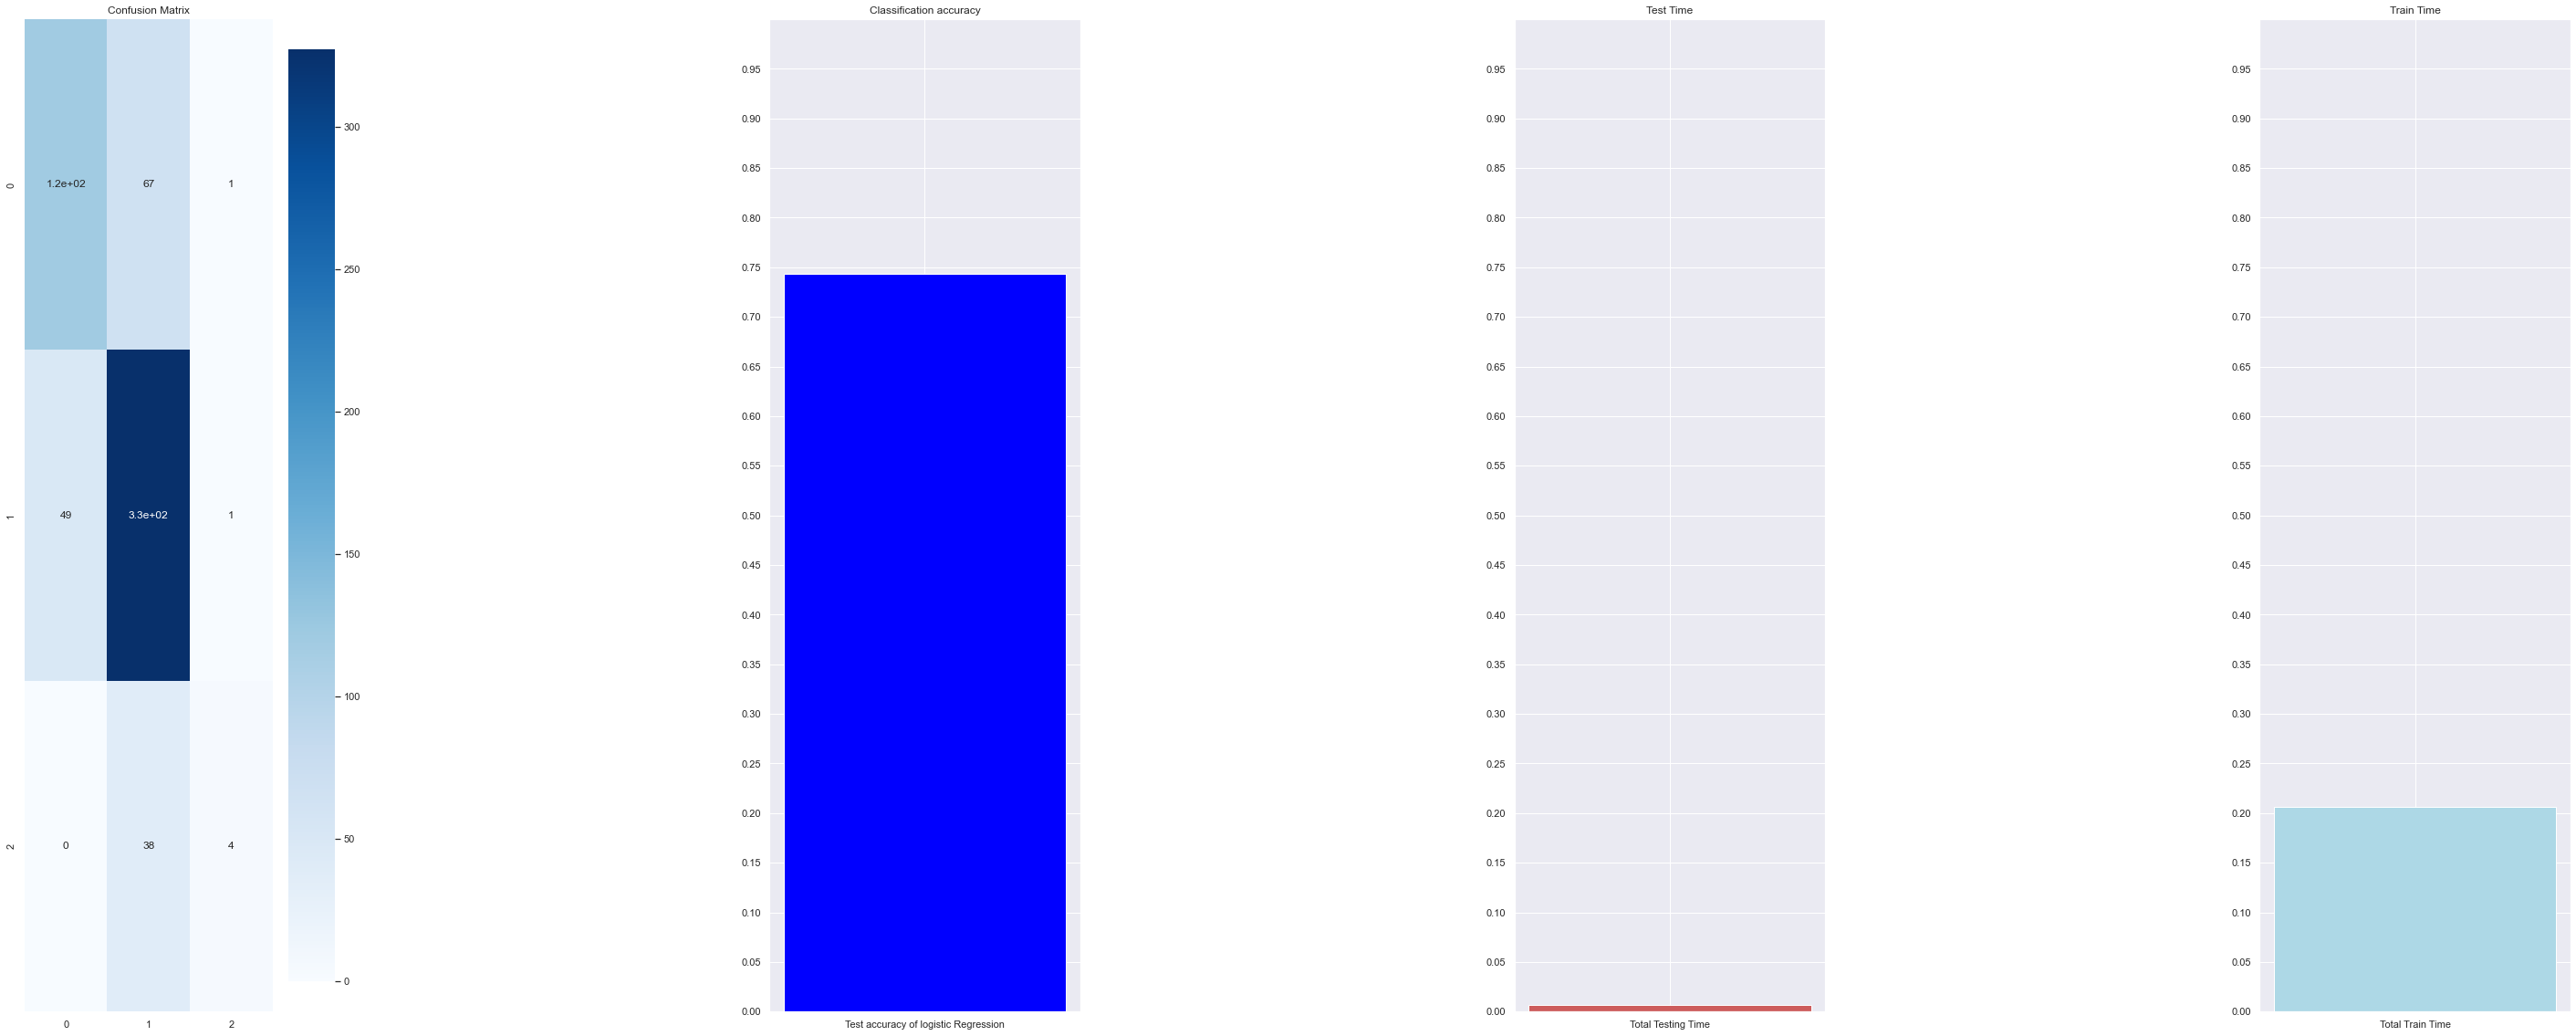

accuracy: 0.7331136738056013 Params: {'penalty': 'l2', 'C': 0.1, 'solver': 'lbfgs'}
accuracy: 0.7347611202635914 Params: {'penalty': 'l2', 'C': 0.1, 'solver': 'liblinear'}
accuracy: 0.7331136738056013 Params: {'penalty': 'l2', 'C': 0.1, 'solver': 'newton-cg'}
accuracy: 0.7331136738056013 Params: {'penalty': 'l2', 'C': 0.1, 'solver': 'sag'}
accuracy: 0.7331136738056013 Params: {'penalty': 'l2', 'C': 0.1, 'solver': 'saga'}
accuracy: 0.6869851729818781 Params: {'penalty': 'l2', 'C': 0.001, 'solver': 'lbfgs'}
accuracy: 0.6820428336079077 Params: {'penalty': 'l2', 'C': 0.001, 'solver': 'liblinear'}
accuracy: 0.6869851729818781 Params: {'penalty': 'l2', 'C': 0.001, 'solver': 'newton-cg'}
accuracy: 0.6869851729818781 Params: {'penalty': 'l2', 'C': 0.001, 'solver': 'sag'}
accuracy: 0.6869851729818781 Params: {'penalty': 'l2', 'C': 0.001, 'solver': 'saga'}
accuracy: 0.7331136738056013 Params: {'penalty': 'l2', 'C': 1.5, 'solver': 'lbfgs'}
accuracy: 0.7331136738056013 Params: {'penalty': 'l2', '

In [65]:
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# define models and parameters
model = LogisticRegression()
param_grid = {'penalty': ['l2'], 'C':[0.1,0.001,1.5,1.3,1.4,1.0,0.9,0.2,0.3], 'solver':['lbfgs', 'liblinear', 'newton-cg','sag', 'saga']}
tuning = HyperTuning()


# Search for best hyperparameters
best_params = tuning.search(model, param_grid, x_train, y_train, x_test, y_test)

# Train a new model with the best hyperparameters on the combined training and validation sets
Logistic_Regression_Model = LogisticRegression(**best_params)

# Record start time of training
start_train_time = time.time()

# Train the model
Logistic_Regression_Model.fit(x_train, y_train)

# Record end time of training
end_train_time = time.time()


# Calculate total training time and total test time
total_train_time = end_train_time - start_train_time
print("Total training time:", total_train_time, "seconds")



fig, ax = plt.subplots(1, 4, figsize=(16,6))

# find the test accurracy
predictWithMatrix(Logistic_Regression_Model,x_test,y_test,"test","logistic Regression")
# find the training accurracy
model_prediction(Logistic_Regression_Model,x_train,y_train,"train","logistic Regression")


# Plot bar graphs for accuracy, training time, and testing time
ax[3].bar(["Total Train Time"], [total_train_time], color=["#ADD8E6"])
ax[3].set_title('Train Time')
ax[3].set_ylim([0.0, 1])
ax[3].set_yticks(np.arange(0, 1, step=0.05))

plt.subplots_adjust(wspace=1.4)
plt.show()


# tuning.print_max_row()
tuning.print_params_results()

# Gradient Boosting

Train time: 1.240471601486206 seconds
test Accuracy of Gradient_Boosting: 0.7495881383855024
Test time: 0.012087821960449219 seconds
train Accuracy of Gradient_Boosting: 0.7896907216494845


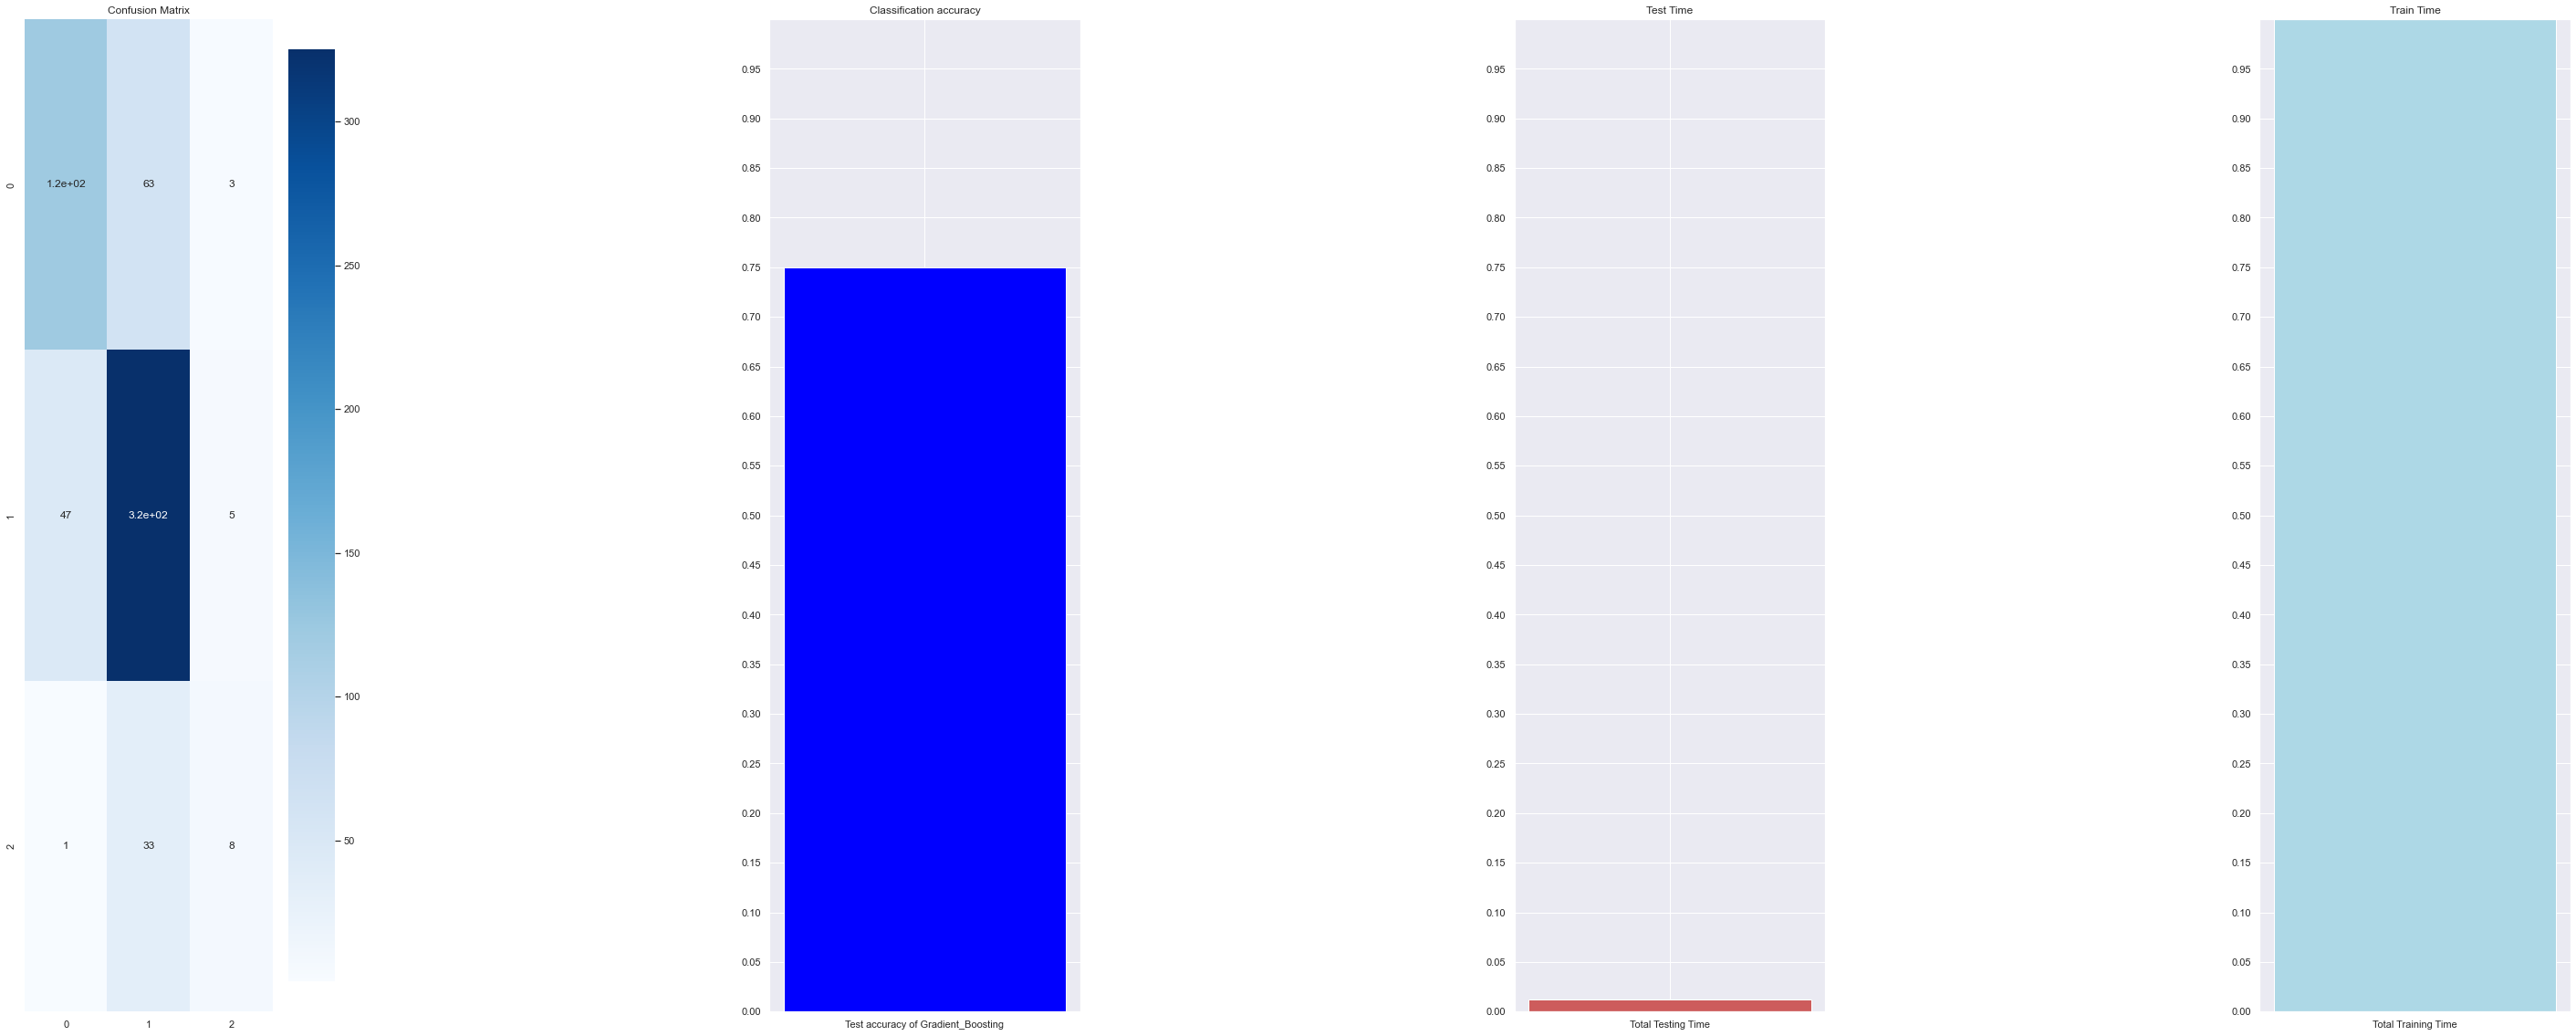

accuracy: 0.6820428336079077 Params: {'n_estimators': 40, 'max_depth': 1, 'learning_rate': 0.1}
accuracy: 0.7018121911037891 Params: {'n_estimators': 40, 'max_depth': 1, 'learning_rate': 0.2}
accuracy: 0.7232289950576606 Params: {'n_estimators': 40, 'max_depth': 1, 'learning_rate': 0.3}
accuracy: 0.7018121911037891 Params: {'n_estimators': 40, 'max_depth': 2, 'learning_rate': 0.1}
accuracy: 0.7199341021416804 Params: {'n_estimators': 40, 'max_depth': 2, 'learning_rate': 0.2}
accuracy: 0.7446457990115322 Params: {'n_estimators': 40, 'max_depth': 2, 'learning_rate': 0.3}
accuracy: 0.7265238879736409 Params: {'n_estimators': 40, 'max_depth': 3, 'learning_rate': 0.1}
accuracy: 0.7314662273476112 Params: {'n_estimators': 40, 'max_depth': 3, 'learning_rate': 0.2}
accuracy: 0.7397034596375618 Params: {'n_estimators': 40, 'max_depth': 3, 'learning_rate': 0.3}
accuracy: 0.728171334431631 Params: {'n_estimators': 40, 'max_depth': 4, 'learning_rate': 0.1}
accuracy: 0.7347611202635914 Params: {'n_

In [66]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time

# define models and parameters
model = GradientBoostingClassifier()
param_grid = {'n_estimators': [40,41,42,43,44], 'max_depth':[1,2,3,4,5], 'learning_rate':[0.1, 0.2,0.3]}

tuning = HyperTuning()

# Search for best hyperparameters
best_params = tuning.search(model, param_grid, x_train, y_train, x_test, y_test)

# Train a new model with the best hyperparameters on the combined training and validation sets
Gradient_Boosting_model = GradientBoostingClassifier(**best_params)



# Record start time of training
start_train_time = time.time()

# Train the model
Gradient_Boosting_model.fit(x_train, y_train)

# Record end time of training
end_train_time = time.time()


# Calculate total training time and total test time
total_train_time = end_train_time - start_train_time
print("Train time:", total_train_time, "seconds")



fig, ax = plt.subplots(1, 4, figsize=(16,6))

# find the test accurracy
predictWithMatrix(Gradient_Boosting_model,x_test,y_test,"test","Gradient_Boosting")
# find the training accurracy
model_prediction(Gradient_Boosting_model,x_train,y_train,"train","Gradient_Boosting")


# Plot bar graphs for accuracy, training time, and testing time
ax[3].bar(["Total Training Time"], [total_train_time], color=["#ADD8E6"])
ax[3].set_title('Train Time')
ax[3].set_ylim([0.0, 1])
ax[3].set_yticks(np.arange(0, 1, step=0.05))

plt.subplots_adjust(wspace=1.4)
plt.show()


# tuning.print_max_row()
tuning.print_params_results()

# Voting

Train time: 2.2359619140625 seconds
test Accuracy of Voting: 0.7561779242174629
Test time: 2.0628135204315186 seconds
train Accuracy of Voting: 0.777319587628866


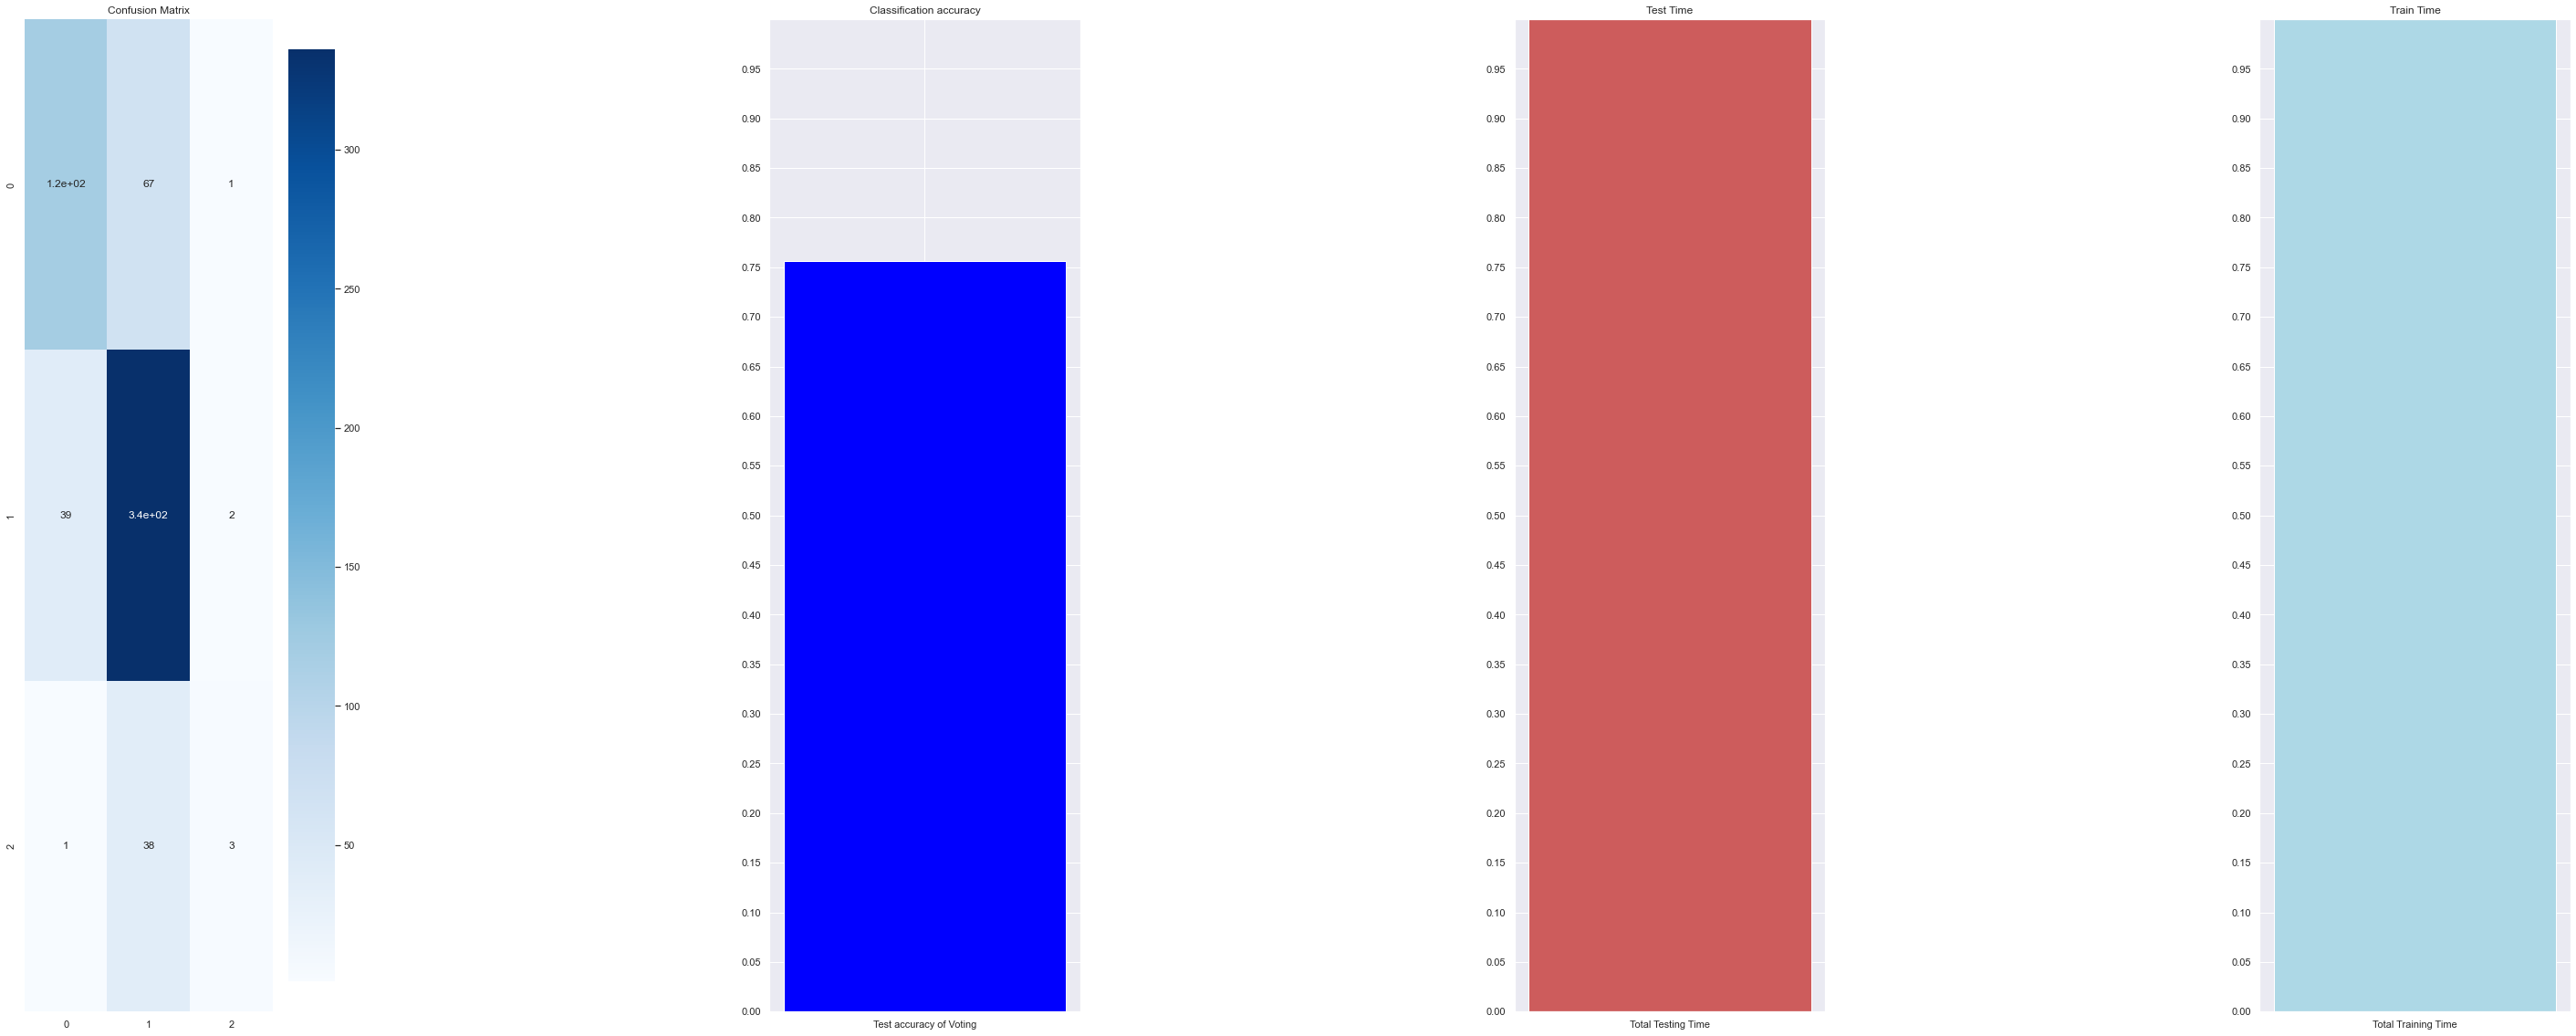

In [67]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(estimators=[('svm', svm_model),('lr', Logistic_Regression_Model), ('gb', Gradient_Boosting_model)], voting='hard')
#ensemble = VotingClassifier(estimators=[('lr', lr),('svm', svm_model), ('nb', random_forest_model), ('dt', Gradient_Boosting_model),  ('nc', Linear_Discriminant_model)], voting='hard')



# Record start time of training
start_train_time = time.time()

# Train the model
ensemble.fit(x_train, y_train)

# Record end time of training
end_train_time = time.time()


# Calculate total training time and total test time
total_train_time = end_train_time - start_train_time
print("Train time:", total_train_time, "seconds")



fig, ax = plt.subplots(1, 4, figsize=(16,6))

# find the test accurracy
predictWithMatrix(ensemble,x_test,y_test,"test","Voting")
# find the training accurracy
model_prediction(ensemble,x_train,y_train,"train","Voting")


# Plot bar graphs for accuracy, training time, and testing time
ax[3].bar(["Total Training Time"], [total_train_time], color=["#ADD8E6"])
ax[3].set_title('Train Time')
ax[3].set_ylim([0.0, 1])
ax[3].set_yticks(np.arange(0, 1, step=0.05))

plt.subplots_adjust(wspace=1.4)
plt.show()